In [1]:
### 입력으로 상호명을 받으면 업종분류를 반환하는 프로그램

In [34]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os

from tqdm import tqdm
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizerFast, BertConfig, BertModel # Bert 모델과 토크나이저
from torch.utils.data import Dataset, DataLoader

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
torch.cuda.init()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_peak_memory_stats(device=None)
print("현재 디바이스:", device)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

현재 디바이스: cuda


In [3]:
# 전처리된 CSV 파일 로드
def load_processed_data(file_path):
    """
    처리된 CSV 파일을 로드하는 함수
    """
    df = pd.read_csv(file_path)
    print(f"로드된 데이터 크기: {df.shape}")
    print(f"컬럼 목록: {df.columns.tolist()}")
    
    # 필요한 열만 추출 (업체명과 클래스)
    result_df = df[['상호명_Regulated', '클래스']].copy()
    
    # 컬럼명 통일
    result_df.columns = ['store', 'class']
    
    print(f"전처리 후 데이터 크기: {result_df.shape}")
    return result_df

In [4]:
data_df = load_processed_data('./processed_data/seoul_gyeonggi_combined_data.csv')

로드된 데이터 크기: (881212, 5)
컬럼 목록: ['상가업소번호', '지역', '상호명_Regulated', '업종소분류_Regulated', '클래스']
전처리 후 데이터 크기: (881212, 2)


In [5]:
def split_dataset(df, test_size=0.2, random_state=42):
    """
    데이터를 훈련용과 테스트용으로 분할하는 함수
    """
    # 클래스 분포 확인
    num_classes = df['class'].nunique()
    print(f"고유 클래스 수: {num_classes}")
    
    # 데이터셋 분할 (stratify로 클래스 분포 유지)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        stratify=df['class']
    )
    
    print(f"훈련 데이터 크기: {train_df.shape}")
    print(f"테스트 데이터 크기: {test_df.shape}")

    return train_df, test_df

In [6]:
train_df, test_df = split_dataset(data_df)

고유 클래스 수: 247
훈련 데이터 크기: (704969, 2)
테스트 데이터 크기: (176243, 2)


In [7]:
train_df
# test_df

,store,class
439445,봉암쇼핑,131
868063,밀사랑손칼국수,35
806857,지케이,131
495028,로그인커피,214
244700,영동포차나,95
...,...,...
726190,송희농산,206
485806,풍산우드인테리어,173
209350,태민건축적산사무소,17
703804,운산검도관,222


In [8]:
train_df.groupby(by=['class']).count()

,store
class,
0,1774
1,2633
2,338
3,1332
4,394
...,...
242,393
243,243
244,6994


In [9]:
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base')
token1 = tokenizer.tokenize("봉암쇼핑")
token2 = tokenizer.tokenize("밀사랑손칼국수")
token3 = tokenizer.tokenize("태민건축적산사무소")
token4 = tokenizer.tokenize("스타벅스R리저브강남대로점")
token5 = tokenizer.tokenize("로그인커피")
token1, token2, token3, token4, token5

(['봉', '##암', '##쇼핑'],
 ['밀', '##사랑', '##손', '##칼국수'],
 ['태', '##민', '##건축', '##적', '##산', '##사무소'],
 ['스타벅스', '##r', '##리', '##저', '##브', '##강', '##남', '##대로', '##점'],
 ['로그인', '##커피'])

In [10]:
class TokenDataset(Dataset):
  
    def __init__(self, dataframe, tokenizer_pretrained):
        # sentence, label 컬럼으로 구성된 데이터프레임 전달
        self.data = dataframe        
        # Huggingface 토크나이저 생성
        self.tokenizer = BertTokenizerFast.from_pretrained(tokenizer_pretrained)
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, idx):
        sentence = self.data.iloc[idx]['store']
        label = self.data.iloc[idx]['class']

        # 토큰화 처리
        tokens = self.tokenizer(
            str(sentence),                # 1개 문장 
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            max_length=60,          # 최대 길이 60
            add_special_tokens=True  # 스페셜 토큰 적용
        )

        input_ids = tokens['input_ids'].squeeze(0)           # 2D -> 1D
        attention_mask = tokens['attention_mask'].squeeze(0) # 2D -> 1D
        token_type_ids = torch.zeros_like(attention_mask)

        # input_ids, attention_mask, token_type_ids 이렇게 3가지 요소를 반환하도록 합니다.
        # input_ids: 토큰
        # attention_mask: 실제 단어가 존재하면 1, 패딩이면 0 (패딩은 0이 아닐 수 있습니다)
        # token_type_ids: 문장을 구분하는 id. 단일 문장인 경우에는 전부 0
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask, 
            'token_type_ids': token_type_ids,
        }, torch.tensor(label)

In [11]:
train_data = TokenDataset(train_df, 'kykim/bert-kor-base')
test_data = TokenDataset(test_df, 'kykim/bert-kor-base')

# DataLoader로 이전에 생성한 Dataset를 지정하여, batch 구성, shuffle, num_workers 등을 설정합니다.
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, num_workers=0)

In [13]:
# 1개의 batch 꺼내기
inputs, labels = next(iter(train_loader))

# 데이터셋을 device 설정
inputs = {k: v.to(device) for k, v in inputs.items()}
labels.to(device)

tensor([236, 107, 238,  28, 211, 180, 214, 114, 180,  87, 169, 237,  77, 190,
        181,  67], device='cuda:0')

In [14]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'token_type_ids'])

In [15]:
inputs['input_ids'].shape, inputs['attention_mask'].shape, inputs['token_type_ids'].shape, labels.shape

(torch.Size([16, 60]),
 torch.Size([16, 60]),
 torch.Size([16, 60]),
 torch.Size([16]))

In [16]:
config = BertConfig.from_pretrained('kykim/bert-kor-base')
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "embedding_size": 768,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 42000
}

In [17]:
labels

tensor([236, 107, 238,  28, 211, 180, 214, 114, 180,  87, 169, 237,  77, 190,
        181,  67])

In [18]:
model_bert = BertModel.from_pretrained('kykim/bert-kor-base').to(device)
model_bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(42000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
outputs = model_bert(**inputs)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [20]:
outputs['last_hidden_state'].shape, outputs['pooler_output'].shape

(torch.Size([16, 60, 768]), torch.Size([16, 768]))

In [21]:
last_hidden_state = outputs['last_hidden_state']
print(last_hidden_state.shape)
print(last_hidden_state[:, 0, :])

torch.Size([16, 60, 768])
tensor([[ 0.3889,  0.7785, -0.4210,  ...,  0.2288, -0.4395,  1.0024],
        [ 0.4229, -0.0694, -0.3771,  ..., -0.3690, -0.2073,  0.1891],
        [ 0.3145,  0.3594, -0.4526,  ..., -0.7469, -1.0386,  0.4535],
        ...,
        [-0.3177,  0.3608, -0.7161,  ..., -0.4788,  0.7125,  1.0540],
        [-0.2814, -0.0374, -0.9342,  ..., -0.6016, -0.3406,  0.0074],
        [ 0.7808,  0.5486, -0.7555,  ..., -0.3563, -0.3593, -0.5289]],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [22]:
pooler_output = outputs['pooler_output']
print(pooler_output.shape)
print(pooler_output)

torch.Size([16, 768])
tensor([[ 0.9462,  0.1012, -0.9985,  ..., -0.9000,  0.8286,  0.8820],
        [ 0.7810,  0.1719, -0.9995,  ...,  0.5723,  0.7669,  0.1481],
        [ 0.9581, -0.0675, -0.9962,  ..., -0.5679,  0.7653,  0.9304],
        ...,
        [ 0.9121,  0.4248, -0.9976,  ..., -0.6431,  0.7036,  0.4612],
        [ 0.8875,  0.6341, -0.9947,  ...,  0.0444,  0.6470,  0.2392],
        [ 0.9510,  0.2907, -0.9997,  ..., -0.7979,  0.6737, -0.0592]],
       device='cuda:0', grad_fn=<TanhBackward0>)


In [23]:
fc = nn.Linear(768, 247)
fc.to(device)
fc_output = fc(last_hidden_state[:, 0, :])
print(fc_output.shape)
print(fc_output.argmax(dim=1))

torch.Size([16, 247])
tensor([192,  38, 192,  38, 189, 189,  89, 189, 189, 137,  38, 199, 199, 137,
        199,  29], device='cuda:0')


In [24]:
class CustomBertModel(nn.Module):
    def __init__(self, bert_pretrained, dropout_rate=0.5):
        # 부모클래스 초기화
        super(CustomBertModel, self).__init__()
        # 사전학습 모델 지정
        self.bert = BertModel.from_pretrained(bert_pretrained)
        # dropout 설정
        self.dr = nn.Dropout(p=dropout_rate)
        # 최종 출력층 정의
        self.fc = nn.Linear(768, 247)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        # 입력을 pre-trained bert model 로 대입
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # 결과의 last_hidden_state 가져옴
        last_hidden_state = output['last_hidden_state']
        # last_hidden_state[:, 0, :]는 [CLS] 토큰을 가져옴
        x = self.dr(last_hidden_state[:, 0, :])
        # FC 을 거쳐 최종 출력
        x = self.fc(x)
        return x

In [12]:
class ImprovedBertModel(nn.Module):
    def __init__(self, bert_pretrained, num_classes=247, dropout_rate=0.3):
        super(ImprovedBertModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_pretrained)
        
        # 더 복잡한 분류기 추가
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs['last_hidden_state'][:, 0, :]
        logits = self.classifier(pooled_output)
        return logits

In [26]:
# bert = CustomBertModel('kykim/bert-kor-base')
bert = ImprovedBertModel('kykim/bert-kor-base')
bert.to(device)

ImprovedBertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [27]:
# loss 정의: CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저 정의: bert.paramters()와 learning_rate 설정
optimizer = optim.Adam(bert.parameters(), lr=1e-5)

In [28]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    counts = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader, unit='batch', total=len(data_loader), mininterval=1)
    
    # mini-batch 학습을 시작합니다.
    for idx, (inputs, labels) in enumerate(prograss_bar):
        # inputs, label 데이터를 device 에 올립니다. (cuda:0 혹은 cpu)
        inputs = {k:v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(**inputs)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, labels)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(labels).sum().item()
        counts += len(labels)
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * labels.size(0)
        
        # 프로그레스바에 학습 상황 업데이트
        prograss_bar.set_description(f"training loss: {running_loss/(idx+1):.5f}, training accuracy: {corr / counts:.5f}")
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [29]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for inputs, labels in data_loader:
            # inputs, label 데이터를 device 에 올립니다. (cuda:0 혹은 cpu)
            inputs = {k:v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(**inputs)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(labels)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, labels).item() * labels.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [30]:
num_epochs = 10

# checkpoint로 저장할 모델의 이름을 정의 합니다.
model_name = 'bert-kor-base'

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(bert, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(bert, test_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(bert.state_dict(), f'{model_name}.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

training loss: 37.76791, training accuracy: 0.51918: 100%|██████████| 44061/44061 [1:40:59<00:00,  7.27batch/s]


[INFO] val_loss has been improved from inf to 1.81895. Saving Model!
epoch 01, loss: 2.36052, acc: 0.51918, val_loss: 1.81895, val_accuracy: 0.59929


training loss: 29.30642, training accuracy: 0.59967: 100%|██████████| 44061/44061 [1:40:58<00:00,  7.27batch/s]


[INFO] val_loss has been improved from 1.81895 to 1.72037. Saving Model!
epoch 02, loss: 1.83167, acc: 0.59967, val_loss: 1.72037, val_accuracy: 0.61744


training loss: 27.32278, training accuracy: 0.61890: 100%|██████████| 44061/44061 [1:41:52<00:00,  7.21batch/s]


[INFO] val_loss has been improved from 1.72037 to 1.67492. Saving Model!
epoch 03, loss: 1.70769, acc: 0.61890, val_loss: 1.67492, val_accuracy: 0.62254


training loss: 26.01053, training accuracy: 0.63238: 100%|██████████| 44061/44061 [1:43:13<00:00,  7.11batch/s]


[INFO] val_loss has been improved from 1.67492 to 1.66162. Saving Model!
epoch 04, loss: 1.62567, acc: 0.63238, val_loss: 1.66162, val_accuracy: 0.62636


training loss: 24.91992, training accuracy: 0.64482: 100%|██████████| 44061/44061 [1:44:11<00:00,  7.05batch/s]


[INFO] val_loss has been improved from 1.66162 to 1.65743. Saving Model!
epoch 05, loss: 1.55751, acc: 0.64482, val_loss: 1.65743, val_accuracy: 0.62856


training loss: 23.94375, training accuracy: 0.65473: 100%|██████████| 44061/44061 [1:43:09<00:00,  7.12batch/s]


epoch 06, loss: 1.49650, acc: 0.65473, val_loss: 1.65814, val_accuracy: 0.62981


training loss: 23.01488, training accuracy: 0.66448: 100%|██████████| 44061/44061 [1:43:26<00:00,  7.10batch/s]


epoch 07, loss: 1.43844, acc: 0.66448, val_loss: 1.68317, val_accuracy: 0.62869


training loss: 22.12047, training accuracy: 0.67463: 100%|██████████| 44061/44061 [2:37:18<00:00,  4.67batch/s]  


epoch 08, loss: 1.38254, acc: 0.67463, val_loss: 1.70544, val_accuracy: 0.62737


training loss: 21.25136, training accuracy: 0.68488: 100%|██████████| 44061/44061 [1:54:29<00:00,  6.41batch/s]


epoch 09, loss: 1.32822, acc: 0.68488, val_loss: 1.72500, val_accuracy: 0.62732


training loss: 20.37799, training accuracy: 0.69507: 100%|██████████| 44061/44061 [1:44:26<00:00,  7.03batch/s]


epoch 10, loss: 1.27364, acc: 0.69507, val_loss: 1.76508, val_accuracy: 0.62565


In [13]:
history = {
    'loss':     [2.36052, 1.83167, 1.70769, 1.62567, 1.55751, 1.49650, 1.43844, 1.38254, 1.32822, 1.27364],
    'acc':      [0.51918, 0.59967, 0.61890, 0.63238, 0.64482, 0.65473, 0.66448, 0.67463, 0.68488, 0.69507],
    'val_loss': [1.81895, 1.72037, 1.67492, 1.66162, 1.65743, 1.65814, 1.68317, 1.70544, 1.72500, 1.76508],
    'val_acc':  [0.59929, 0.61744, 0.62254, 0.62636, 0.62856, 0.62981, 0.62869, 0.62737, 0.62732, 0.62565]
}

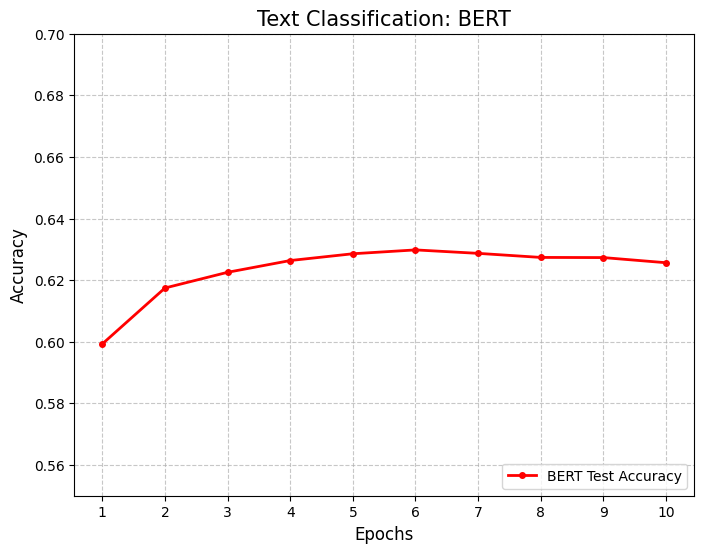

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(history["val_acc"], 'r.-', label='BERT Test Accuracy', linewidth=2, markersize=8)

plt.title('Text Classification: BERT', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(10),range(1,11))
plt.ylim(0.55, 0.7)
plt.legend(loc='lower right', fontsize=10, frameon=True)
plt.show()

In [5]:
model_name = 'bert-kor-base' #weighted loss 추가, 병렬 커널 사용, 오버샘플링 추가
time_date = '2505042240'
save_path = './saved_model/'
pickle.dump(history, open(os.path.join(save_path, f'{model_name}{time_date}/{model_name}{time_date}_history.pkl'), 'wb'))

In [33]:
bert.load_state_dict(torch.load(f'{model_name}.pth'))

<All keys matched successfully>

In [ ]:
# 모델 가중치 저장
torch.save(bert.state_dict(), './saved_model/bert-kor-base2505042240.pth')

# 모델 구성 저장
with open('./saved_model/bert-kor-base2505042240/bert-kor-base2505042240_config.json', 'w') as f:
    f.write(config.to_json_string())

In [ ]:
bert = ImprovedBertModel('kykim/bert-kor-base')
bert.load_state_dict(torch.load('./saved_model/bert-kor-base2505042240/bert-kor-base2505042240.pth'))
bert.to(device)
bert.eval() # 평가모드

In [65]:
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base')
labels = pickle.load(open('./processed_data/category_mapping.pkl', 'rb'))
labels = {v: k for k, v in labels.items()}
labels

{'0': 'PC방',
 '1': '가구 ',
 '2': '가발 ',
 '3': '가방 ',
 '4': '가스 충전소',
 '5': '가전제품 ',
 '6': '가전제품 수리',
 '7': '가정용 연료 ',
 '8': '가죽/가방/신발 수선',
 '9': '가축 사료 ',
 '10': '간이 음식점(기타)',
 '11': '개인/가정용품 수리(기타)',
 '12': '건강보조식품 ',
 '13': '건물 및 토목 엔지니어링 서비스',
 '14': '건설/건축자재 ',
 '15': '건설기계/장비 대여업',
 '16': '건어물/젓갈 ',
 '17': '건축 설계 및 관련 서비스',
 '18': '건축물 일반 청소',
 '19': '결혼 상담 서비스',
 '20': '경양식',
 '21': '경영 컨설팅',
 '22': '고용 알선업',
 '23': '곡물/곡분 ',
 '24': '골프 연습장',
 '25': '곱창 전골/구이',
 '26': '공인노무사',
 '27': '공인회계사',
 '28': '광고 대행',
 '29': '광고 매체 판매',
 '30': '광고물 설계/제작업',
 '31': '교육기관(기타)',
 '32': '교육컨설팅',
 '33': '구내식당',
 '34': '국/탕/찌개류',
 '35': '국수/칼국수',
 '36': '기념품점',
 '37': '기숙사/고시원',
 '38': '기타 개인/가정용품 대여업',
 '39': '기타 건설/건축자재 ',
 '40': '기타 광고 관련 서비스',
 '41': '기타 교육지원 서비스',
 '42': '기타 기술/직업 훈련학원',
 '43': '기타 동남아식 전문',
 '44': '기타 법무관련 서비스',
 '45': '기타 사무 지원 서비스',
 '46': '기타 산업용 기계/장비 대여업',
 '47': '기타 서양식 음식점',
 '48': '기타 스포츠시설 운영업',
 '49': '기타 엔지니어링 서비스',
 '50': '기타 여행 보조/예약 서비스',
 '51': '기타 예술/스포츠 교육기

In [100]:
class CustomPredictor():
    def __init__(self, model, tokenizer, labels: dict):
        self.model = model
        self.tokenizer = tokenizer
        self.labels = labels
        
    def predict(self, sentence):
        # 토큰화 처리
        tokens = self.tokenizer(
            str(sentence),                # 1개 문장 
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            max_length=60,          # 최대 길이 60
            add_special_tokens=True  # 스페셜 토큰 적용
        )
        tokens.to(device)
        prediction = self.model(**tokens)
        prediction = F.softmax(prediction, dim=1)
        output = prediction.argmax(dim=1).item()
        prob = prediction.max(dim=1)[0].item() * 100
        result = self.labels[str(output)]
        return result, prob

In [108]:
predictor = CustomPredictor(bert, tokenizer, labels)

for i in range(10):
    query = test_df.iloc[i]['store']
    pred, acc = predictor.predict(query)
    print(f'{query} -> {pred} ({acc:.2f}%)')
query = "스타벅스R리저브강남대로점"
pred = predictor.predict(query)
print(query, pred)

손끝차이헤어플러스 -> 미용실 (99.73%)
와이비오토서비스 -> 자동차 정비소 (65.83%)
에이헤어 -> 미용실 (99.82%)
노보잼 -> 카페 (9.19%)
인디안미아지점 -> 기타 의류  (50.37%)
박군치킨죽백점 -> 치킨 (99.92%)
탑K골프 -> 운동용품  (52.34%)
더세컨사이트 -> 경영 컨설팅 (66.99%)
시화법무사사무소 -> 법무사 (99.88%)
뉴욕포차와치킨클럽 -> 요리 주점 (50.05%)
스타벅스R리저브강남대로점 ('카페', 98.0905294418335)


In [82]:
def batch_predict(model, dataloader, labels_dict, device):
    """배치 단위로 예측 수행"""
    model.eval()
    results = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            # 디바이스로 데이터 이동
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            
            # 예측 수행
            outputs = model(**inputs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            confidence = torch.max(probs, dim=1)[0]
            
            # 결과 저장
            for i in range(len(labels)):
                pred_class = labels_dict[str(preds[i].item())]
                true_class = labels_dict[str(labels[i].item())]
                results.append({
                    'query': test_df.iloc[i]['store'],
                    'pred': pred_class,
                    'label': true_class,
                    'prob': f'{confidence[i].item()*100:.2f}%'
                })
    
    return pd.DataFrame(results)

# 평가용 데이터로더 설정 (배치 크기 증가)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

# 배치 예측 실행
test_query_df = batch_predict(bert, test_loader, labels, device)

100%|██████████| 2754/2754 [06:15<00:00,  7.33it/s]


In [90]:
test_query_df.head(20)

,query,pred,label,prob
0,손끝차이헤어플러스,미용실,미용실,99.73%
1,와이비오토서비스,자동차 정비소,자동차 세차장,65.83%
2,에이헤어,미용실,미용실,99.82%
3,노보잼,카페,기타 광고 관련 서비스,9.19%
4,인디안미아지점,기타 의류,여성 의류,50.37%
5,박군치킨죽백점,치킨,치킨,99.92%
6,탑K골프,운동용품,운동용품,52.34%
7,더세컨사이트,경영 컨설팅,광고물 설계/제작업,66.99%
8,시화법무사사무소,법무사,법무사,99.88%
9,뉴욕포차와치킨클럽,요리 주점,요리 주점,50.05%


In [87]:
score = test_query_df['pred'].eq(test_query_df['label']).sum() / len(test_query_df) * 100
score

np.float64(62.85639713350317)

In [103]:
# Error Analysis
error_df = test_query_df[test_query_df['pred'] != test_query_df['label']].copy()
error_df.head(20)

,query,pred,label,prob
1,와이비오토서비스,자동차 정비소,자동차 세차장,65.83%
3,노보잼,카페,기타 광고 관련 서비스,9.19%
4,인디안미아지점,기타 의류,여성 의류,50.37%
7,더세컨사이트,경영 컨설팅,광고물 설계/제작업,66.99%
12,제이엠인터내셔널,경영 컨설팅,변리사,17.39%
13,우리중량,건설기계/장비 대여업,기타 엔지니어링 서비스,14.61%
19,녹향원,중국집,횟집,71.00%
20,한결에이엠,경영 컨설팅,임시/일용 인력 공급업,18.34%
25,장생호,수산물,예술품,62.49%
29,모잇,카페,가방,15.32%


In [104]:
pickle.dump(test_query_df, open('./saved_model/bert-kor-base2505042240/test_query_df.pkl', 'wb'))
pickle.dump(error_df, open('./saved_model/bert-kor-base2505042240/error_df.pkl', 'wb'))

In [21]:
test_query_df = pickle.load(open('./saved_model/bert-kor-base2505042240/test_query_df.pkl', 'rb'))
error_df = pickle.load(open('./saved_model/bert-kor-base2505042240/error_df.pkl', 'rb'))
error_df.head(20)

,query,pred,label,prob
1,와이비오토서비스,자동차 정비소,자동차 세차장,65.83%
3,노보잼,카페,기타 광고 관련 서비스,9.19%
4,인디안미아지점,기타 의류,여성 의류,50.37%
7,더세컨사이트,경영 컨설팅,광고물 설계/제작업,66.99%
12,제이엠인터내셔널,경영 컨설팅,변리사,17.39%
13,우리중량,건설기계/장비 대여업,기타 엔지니어링 서비스,14.61%
19,녹향원,중국집,횟집,71.00%
20,한결에이엠,경영 컨설팅,임시/일용 인력 공급업,18.34%
25,장생호,수산물,예술품,62.49%
29,모잇,카페,가방,15.32%


In [22]:
bert_case_counts = (
    error_df.groupby(['pred', 'label'])
    .size()
    .reset_index(name='counts')
    .sort_values(by='counts', ascending=False)
)
bert_case_counts

,pred,label,counts
806,경영 컨설팅,광고 대행,1064
870,경영 컨설팅,부동산 중개/대리,660
3200,백반/한정식,돼지고기 구이/찜,587
5400,요리 주점,백반/한정식,450
2571,돼지고기 구이/찜,백반/한정식,395
...,...,...,...
17,PC방,카페,1
16,PC방,중고 상품,1
15,PC방,주방/가정용품,1
14,PC방,정육점,1


In [29]:
from sklearn.metrics import classification_report
print(classification_report(test_query_df['label'], test_query_df['pred'], digits=4 ,zero_division=0))

                      precision    recall  f1-score   support

                 PC방     0.8981    0.8739    0.8858       444
                 가구      0.6293    0.4954    0.5544       658
                 가발      0.0000    0.0000    0.0000        84
                 가방      0.5814    0.2252    0.3247       333
              가스 충전소     0.8451    0.6122    0.7101        98
               가전제품      0.3145    0.1625    0.2143       480
             가전제품 수리     0.5210    0.4812    0.5003       773
             가정용 연료      0.6517    0.7661    0.7043       171
         가죽/가방/신발 수선     0.7273    0.2927    0.4174        82
              가축 사료      0.2500    0.0137    0.0260        73
          간이 음식점(기타)     0.4952    0.1090    0.1787       477
      개인/가정용품 수리(기타)     0.4333    0.5381    0.4801       604
             건강보조식품      0.5594    0.4623    0.5062      1008
   건물 및 토목 엔지니어링 서비스     0.3589    0.5332    0.4290       632
            건설/건축자재      0.7949    0.4306    0.5586        72
       

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
unique_classes = sorted(test_query_df['label'].unique())
y_pred = test_query_df['pred'].values
y_true = test_query_df['label'].values
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
cm_df = pd.DataFrame(cm)

cm_df

,0,1,2,3,4,5,6,7,8,9,...,237,238,239,240,241,242,243,244,245,246
0,388,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
1,0,326,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,4,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,0,75,0,1,3,0,0,0,...,0,7,0,0,0,0,0,1,0,0
4,0,0,0,0,60,0,0,18,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,9,0,0,0,0
243,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,18,0,0,0
244,0,1,0,1,0,1,0,0,0,0,...,0,3,0,0,7,0,0,480,0,1
245,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,31,0


In [40]:
def plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=1, topk=9):
    """
    cm: confusion_matrix (numpy array)
    unique_classes: 클래스 이름 리스트 (confusion_matrix의 labels 순서와 동일)
    n: 정답률이 낮은 순서에서 n번째 (1부터 시작)
    topk: 오분류 top k개
    """
    total_counts = cm.sum(axis=1)
    correct_counts = np.diag(cm)
    correct_ratio = correct_counts / (total_counts + 1e-8)
    
    # 정답률 낮은 순서대로 인덱스 정렬
    sorted_idx = np.argsort(correct_ratio)
    nth_idx = sorted_idx[n-1]  # n=1이면 가장 낮은 클래스
    
    row = cm[nth_idx].copy()
    row[nth_idx] = 0  # 자기 자신 제외
    topk_wrong_idx = np.argsort(row)[-topk:][::-1]
    
    selected_idx = [nth_idx] + list(topk_wrong_idx)
    cm_sub = cm[np.ix_(selected_idx, selected_idx)]
    class_labels = [unique_classes[i] for i in selected_idx]
    
    if n <= 0:
        title = f'{abs(n)+1}번째로 정답률이 높은 클래스 + 오분류 top{topk} Confusion Matrix'
    else:
        title = f'{n}번째로 정답률이 낮은 클래스 + 오분류 top{topk} Confusion Matrix'
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_sub,
                annot=True,
                fmt='d',
                cmap='Greys',
                xticklabels=class_labels,
                yticklabels=class_labels,
                linewidths=0.5,
                linecolor='gray',
                cbar=False,
                square=True
                )
    plt.title(title, fontsize=16, pad=15)
    plt.xlabel('예측 클래스', fontsize=13)
    plt.ylabel('실제 클래스', fontsize=13)
    plt.xticks(fontsize=11, rotation=45, ha='right')
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    plt.show()

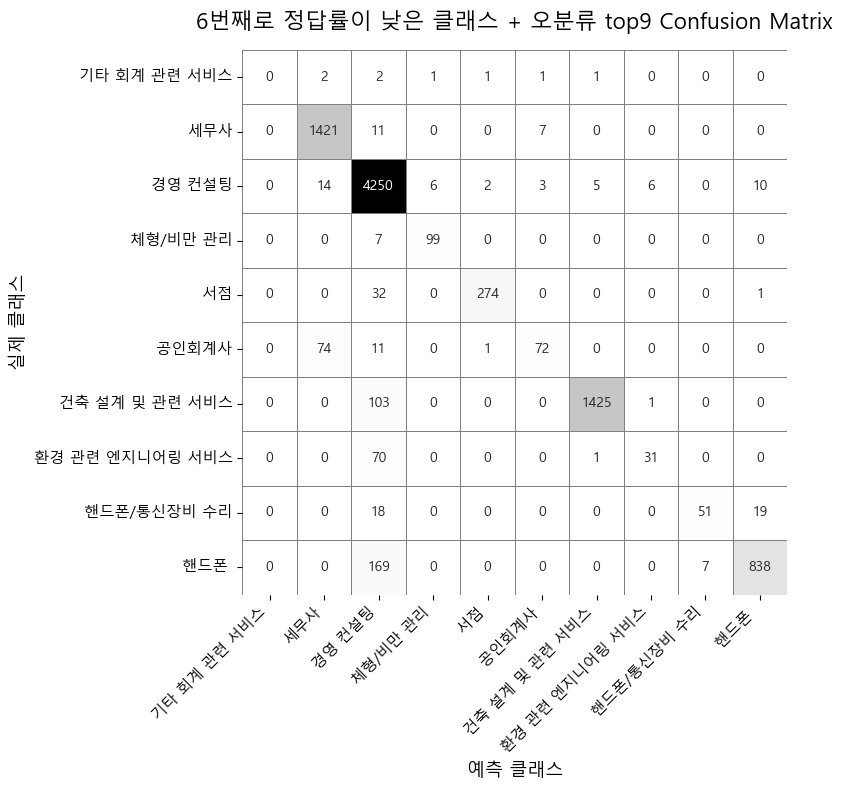

In [46]:
plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=6, topk=9)